In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

Go through and put some plots in - and yes, add on Goalkeepers as best I can

Use Christopher Long's pbp box score data from here - https://github.com/octonion/soccer-m/tree/master/ncaa/csv

Read in the data, which is tab delimited here (pull from Christopher's repo correctly before I publish everything)

In [5]:
df = pd.read_table("~/Desktop/ncaa_pbp", index_col=False)

In [6]:
df.head()

,game_id,section_id,player_id,player_name,player_url,position,goals,assists,sh_att,sog,...,goal_app,ggs,goalie_min_plyd,ga,saves,shutouts,g_wins,g_loss,dsaves,corners
0,4378055,0,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,D,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4378055,0,1807767.0,"Caro, Carlos",http://stats.ncaa.org/player/index?game_sport_...,GK,0,0,0,0,...,1,1,90,1,5,0,0,1,0,0
2,4378055,0,1598828.0,"Celestine, Kyle",http://stats.ncaa.org/player/index?game_sport_...,F,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4378055,0,1703207.0,"Cunningham, Joel",http://stats.ncaa.org/player/index?game_sport_...,D,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4378055,0,1807768.0,"Garwood, Javauni",http://stats.ncaa.org/player/index?game_sport_...,M,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.columns

Index(['game_id', 'section_id', 'player_id', 'player_name', 'player_url',
       'position', 'goals', 'assists', 'sh_att', 'sog', 'fouls', 'red_cards',
       'yellow_cards', 'gc', 'goal_app', 'ggs', 'goalie_min_plyd', 'ga',
       'saves', 'shutouts', 'g_wins', 'g_loss', 'dsaves', 'corners'],
      dtype='object')

Here are the players who have taken the most shots this season:

In [17]:
df.groupby('player_name').sh_att.sum().sort_values(ascending=False)[0:10]

player_name
Totals               42900
Roberts, Kieran         90
Roldan, Alex            90
Guirassy, Mamadou       89
Gallagher, Jon          78
Steeves, Mac            77
Bye, Brandon            77
Donnelly, JJ            70
McGrath, Ian            68
Forrest, Mark           66
Name: sh_att, dtype: int64

90 shots at most is not much. It'd be nice to see if player_id's are consistent across seasons, but, on the other hand, players probably get better from their freshman year to their senior year, so we'd need some weighting scheme to combine shots across all years together. That'd also be _a lot_ of parameters to fit.

Here's the distribution of shot attempts:

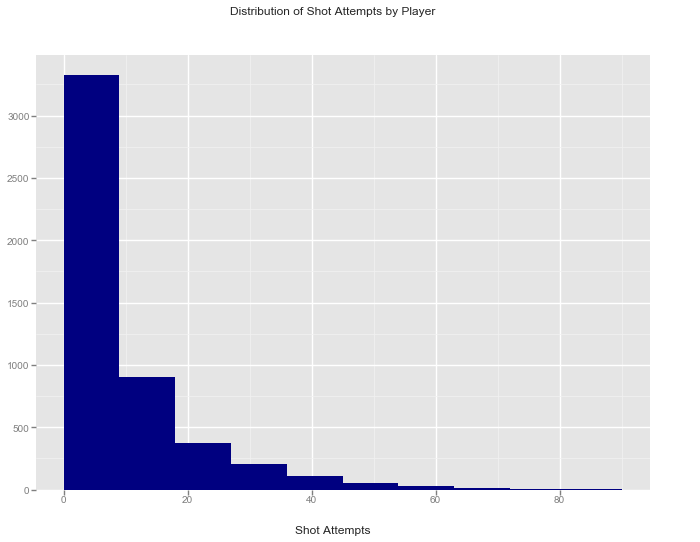

<ggplot: (-9223363289026499019)>

In [25]:
attempts = df.groupby('player_name').sh_att.sum().drop("Totals").to_frame()
g = ggplot(attempts, aes(x="sh_att")) + geom_histogram(fill='navy', lwd=3) + xlab("Shot Attempts")
g + ggtitle("Distribution of Shot Attempts by Player")

In [26]:
attempts[attempts['sh_att'] > 40].shape

(142, 1)

So there's really not much data for most players, but that's okay. We're only interested in those at the top.

Let's look at shooting percentages for the shooters who have taken the most shots:

In [10]:
sht_perc = df.groupby('player_name')[['sh_att', 'goals', '']].sum().reset_index()

In [11]:
sht_perc['percentage'] = sht_perc.goals / sht_perc.sh_att

In [12]:
sht_perc.sort_values('sh_att', ascending=False)[0:10]

,player_name,sh_att,goals,percentage
4589,Totals,42900,4870,0.113520
3884,"Roberts, Kieran",90,15,0.166667
3932,"Roldan, Alex",90,5,0.055556
1808,"Guirassy, Mamadou",89,16,0.179775
1574,"Gallagher, Jon",78,12,0.153846
4375,"Steeves, Mac",77,8,0.103896
687,"Bye, Brandon",77,12,0.155844
1240,"Donnelly, JJ",70,13,0.185714
2892,"McGrath, Ian",68,11,0.161765
1512,"Forrest, Mark",66,15,0.227273


In [108]:
sht_perc[sht_perc['sh_att'] > 30].sort_values('percentage')[0:10]

,player_name,sh_att,goals,percentage
3752,"Ramos, Ozzie",35,0,0.000000
818,"Cei, Ezequiel",37,0,0.000000
766,"Carreras, Marc",32,0,0.000000
2959,"Mendoza, Luis",44,0,0.000000
3694,"Prpa, Luka",38,1,0.026316
396,"Benamna, Donald",37,1,0.027027
545,"Bourret, Clement",36,1,0.027778
4475,"Szklennik, Evan",35,1,0.028571
3492,"Parada, Juan",34,1,0.029412
2564,"Leonard, Eric",34,1,0.029412


Let's look at shooting percentage by shot attemps

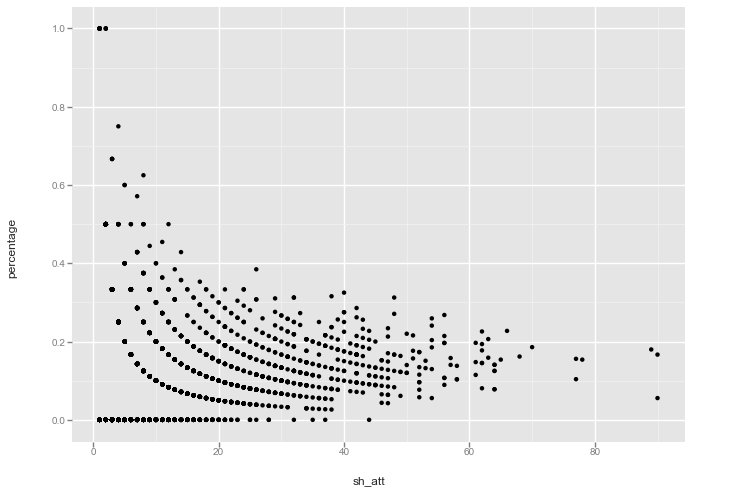

<ggplot: (8747828281927)>

In [29]:
data = sht_perc[sht_perc.player_name != 'Totals']
g = ggplot(data, aes(x='sh_att', y='percentage')) + geom_point()
g

What's the overall shooting percentage?

In [46]:
sum(data.goals) / sum(data.sh_att)

0.11355687170638437

So it's slightly above the MLS average

Here's the distribution of shooting percentages.

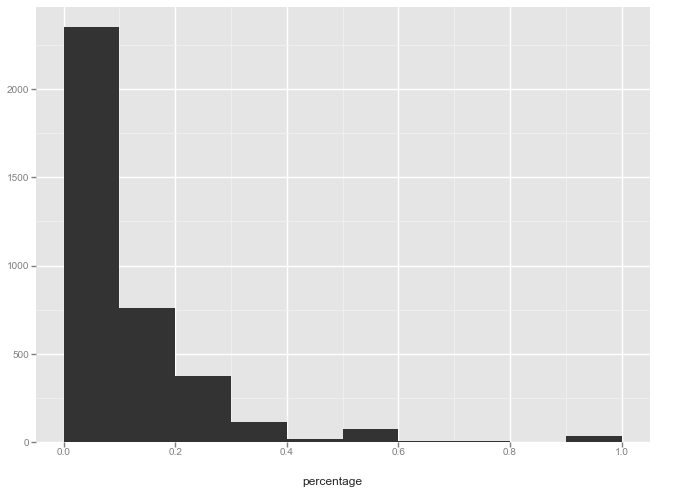

<ggplot: (-9223363289024658919)>

In [43]:
pared = data[data['sh_att'] > 0]
g = ggplot(pared, aes(x='percentage')) + geom_histogram()
g

Neat stuff. Now let's find somewhere we can tack on teams to this, both for and opposition

In [48]:
#rosters = pd.read_table("/home/kcm30/Documents/PracticeR/Whoscored Scraping/2017/jnb/ncaa_rosters.txt")
rosters = pd.read_table("https://raw.githubusercontent.com/octonion/soccer-m/master/ncaa_pbp/csv/ncaa_team_rosters_2018_1.csv")

In [49]:
rosters.head()

,year,year_id,division_id,team_id,team_name,jersey_number,player_id,player_name,player_url,class_year,games_played,games_started
0,2018,12621,1,721,Air Force,12,1800743.0,"Abousaud, Munear",http://stats.ncaa.org/player/index?game_sport_...,So,9,0
1,2018,12621,1,721,Air Force,17,1956389.0,"Angeletti, Jacob",http://stats.ncaa.org/player/index?game_sport_...,Sr,5,1
2,2018,12621,1,721,Air Force,99,1800746.0,"Blessing, Ben",http://stats.ncaa.org/player/index?game_sport_...,So,0,0
3,2018,12621,1,721,Air Force,21,1800744.0,"Blessing, Nick",http://stats.ncaa.org/player/index?game_sport_...,So,18,17
4,2018,12621,1,721,Air Force,7,1692917.0,"Bone, Tucker",http://stats.ncaa.org/player/index?game_sport_...,Jr,18,18


In [50]:
team_player = rosters[['player_id', 'player_name', 'team_id', 'team_name', 'class_year']]

In [51]:
team_player.head()

,player_id,player_name,team_id,team_name,class_year
0,1800743.0,"Abousaud, Munear",721,Air Force,So
1,1956389.0,"Angeletti, Jacob",721,Air Force,Sr
2,1800746.0,"Blessing, Ben",721,Air Force,So
3,1800744.0,"Blessing, Nick",721,Air Force,So
4,1692917.0,"Bone, Tucker",721,Air Force,Jr


In [52]:
team_player[team_player.player_name == 'Cotroneo, Frank']

,player_id,player_name,team_id,team_name,class_year
4432,1793034.0,"Cotroneo, Frank",639,Siena,So
5411,1793034.0,"Cotroneo, Frank",739,Villanova,So


In [53]:
team_player[team_player.player_name == 'Hestnes, Simen']

,player_id,player_name,team_id,team_name,class_year
2379,1706658.0,"Hestnes, Simen",361,LIU Brooklyn,Jr
5808,1706658.0,"Hestnes, Simen",812,Xavier,Jr


Okay so let's just remove those guys from the boxscores

In [54]:
df = df[np.isfinite(df.player_id)]
df = df[df.player_name != 'Hestnes, Simen']
df = df[df.player_name != 'Cotroneo, Frank']

In [55]:
df.shape

(58127, 24)

In [56]:
player_team_df = pd.merge(df, team_player, on=['player_id', 'player_name'], how='left')

In [57]:
df.shape

(58127, 24)

In [58]:
player_team_df.shape

(58127, 27)

In [59]:
len(player_team_df[np.isnan(player_team_df.team_id)].player_name.unique())

103

In [60]:
len(df.player_name.unique())

4905

So we're missing teams for about 2% of players. How many shots is that?

In [61]:
player_team_df[np.isnan(player_team_df.team_id)].sh_att.sum()

21

Just 21 shots, so don't worry about the merge. Though it should just be on player_id instead of that and player_name

In [62]:
boxscores = pd.merge(df, team_player, on=['player_id', 'player_name'], how='inner')

In [63]:
boxscores.columns

Index(['game_id', 'section_id', 'player_id', 'player_name', 'player_url',
       'position', 'goals', 'assists', 'sh_att', 'sog', 'fouls', 'red_cards',
       'yellow_cards', 'gc', 'goal_app', 'ggs', 'goalie_min_plyd', 'ga',
       'saves', 'shutouts', 'g_wins', 'g_loss', 'dsaves', 'corners', 'team_id',
       'team_name', 'class_year'],
      dtype='object')

In [64]:
boxscores.head()

,game_id,section_id,player_id,player_name,player_url,position,goals,assists,sh_att,sog,...,ga,saves,shutouts,g_wins,g_loss,dsaves,corners,team_id,team_name,class_year
0,4378055,0,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,D,0,0,0,0,...,0,0,0,0,0,0,0,290,Howard,Fr
1,4379236,0,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,D,0,0,0,0,...,0,0,0,0,0,0,0,290,Howard,Fr
2,4382728,0,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,D,0,0,0,0,...,0,0,0,0,0,0,0,290,Howard,Fr
3,4391432,0,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,NaN,0,0,0,0,...,0,0,0,0,0,0,0,290,Howard,Fr
4,4393160,1,1912569.0,"Bien-Aime, JB",http://stats.ncaa.org/player/index?game_sport_...,NaN,0,0,0,0,...,0,0,0,0,0,0,0,290,Howard,Fr


Let's get it to the only data we REALLY care about for this - shots and goals

In [65]:
boxscores = boxscores[['game_id', 'player_id', 'player_name',
                       'team_id', 'team_name', 'class_year', 
                       'position', 'goals', 'sh_att']]

In [66]:
boxscores.head()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att
0,4378055,1912569.0,"Bien-Aime, JB",290,Howard,Fr,D,0,0
1,4379236,1912569.0,"Bien-Aime, JB",290,Howard,Fr,D,0,0
2,4382728,1912569.0,"Bien-Aime, JB",290,Howard,Fr,D,0,0
3,4391432,1912569.0,"Bien-Aime, JB",290,Howard,Fr,NaN,0,0
4,4393160,1912569.0,"Bien-Aime, JB",290,Howard,Fr,NaN,0,0


Now let's try to find opponent data we can join on. I guess we can create it ourselves

In [67]:
matchups = boxscores[['game_id', 'team_id', 'team_name']].drop_duplicates()

In [68]:
stats = pd.merge(boxscores, matchups, on='game_id', suffixes=("", "_opposition"))
stats = stats[stats.team_id_opposition != stats.team_id]

In [69]:
stats.head()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
1,4378055,1912569.0,"Bien-Aime, JB",290,Howard,Fr,D,0,0,19651,High Point
3,4378055,1807767.0,"Caro, Carlos",290,Howard,So,GK,0,0,19651,High Point
5,4378055,1598828.0,"Celestine, Kyle",290,Howard,Sr,F,0,0,19651,High Point
7,4378055,1703207.0,"Cunningham, Joel",290,Howard,Jr,D,0,0,19651,High Point
9,4378055,1807768.0,"Garwood, Javauni",290,Howard,So,M,0,1,19651,High Point


In [70]:
boxscores.shape

(58013, 9)

In [71]:
stats.shape

(57825, 11)

In [72]:
t = stats[['game_id', 'team_id_opposition', 'team_id']].drop_duplicates().groupby('game_id').size().sort_values(ascending=False)
t[t > 2]

Series([], dtype: int64)

In [73]:
shots = stats[stats.sh_att > 0]

In [74]:
shots.sh_att.sum()

42508

In [75]:
df.sh_att.sum()

42773

So we're missing about 200 shots - eh. Could be worse I guess

Let's just look at some neat stuff

In [121]:
shots_for = shots.groupby('team_name')[['sh_att', 'goals']].sum()
shots_against = shots.groupby('team_name_opposition')[['sh_att', 'goals']].sum()
tsr = shots_for.join(shots_against, rsuffix='_against')
tsr['tsr'] = tsr['sh_att'] / (tsr['sh_att'] + tsr['sh_att_against'])
tsr['shooting_perc'] = tsr['goals'] / tsr['sh_att']
tsr['shooting_perc_against'] = tsr['goals_against'] / tsr['sh_att_against']

In [130]:
tsr.loc['Duke']

sh_att                   252.000000
goals                     29.000000
sh_att_against           178.000000
goals_against             18.000000
tsr                        0.586047
shooting_perc              0.115079
shooting_perc_against      0.101124
Name: Duke, dtype: float64

In [122]:
tsr.sort_values('tsr', ascending=False)[0:10]

,sh_att,goals,sh_att_against,goals_against,tsr,shooting_perc,shooting_perc_against
team_name,,,,,,,
Seattle U,378,31,117,16,0.763636,0.082011,0.136752
Wake Forest,306,53,109,10,0.737349,0.173203,0.091743
Western Mich.,270,33,116,11,0.699482,0.122222,0.094828
Indiana,320,38,145,4,0.688172,0.118750,0.027586
Columbia,233,27,109,6,0.681287,0.115880,0.055046
Charlotte,266,21,134,19,0.665000,0.078947,0.141791
Army West Point,259,21,132,14,0.662404,0.081081,0.106061
Akron,254,39,130,8,0.661458,0.153543,0.061538
Furman,290,39,150,16,0.659091,0.134483,0.106667


In [123]:
tsr.sort_values('shooting_perc', ascending=False)[0:10]

,sh_att,goals,sh_att_against,goals_against,tsr,shooting_perc,shooting_perc_against
team_name,,,,,,,
FIU,229,46,160,18,0.588689,0.200873,0.112500
North Carolina,247,47,132,15,0.651715,0.190283,0.113636
Gardner-Webb,224,42,285,33,0.440079,0.187500,0.115789
Portland,190,33,193,18,0.496084,0.173684,0.093264
Wake Forest,306,53,109,10,0.737349,0.173203,0.091743
San Francisco,171,29,191,34,0.472376,0.169591,0.178010
Dartmouth,171,29,115,12,0.597902,0.169591,0.104348
Pacific,168,28,168,14,0.500000,0.166667,0.083333
Massachusetts,229,38,231,19,0.497826,0.165939,0.082251


In [131]:
tsr.sort_values('shooting_perc_against', ascending=True)[0:10]

,sh_att,goals,sh_att_against,goals_against,tsr,shooting_perc,shooting_perc_against
team_name,,,,,,,
Indiana,320,38,145,4,0.688172,0.118750,0.027586
Missouri St.,144,15,154,7,0.483221,0.104167,0.045455
Columbia,233,27,109,6,0.681287,0.115880,0.055046
Brown,184,15,217,12,0.458853,0.081522,0.055300
Elon,170,18,195,11,0.465753,0.105882,0.056410
Stanford,293,40,159,9,0.648230,0.136519,0.056604
St. John's (NY),210,21,205,12,0.506024,0.100000,0.058537
Bradley,194,22,270,16,0.418103,0.113402,0.059259
SMU,221,31,151,9,0.594086,0.140271,0.059603


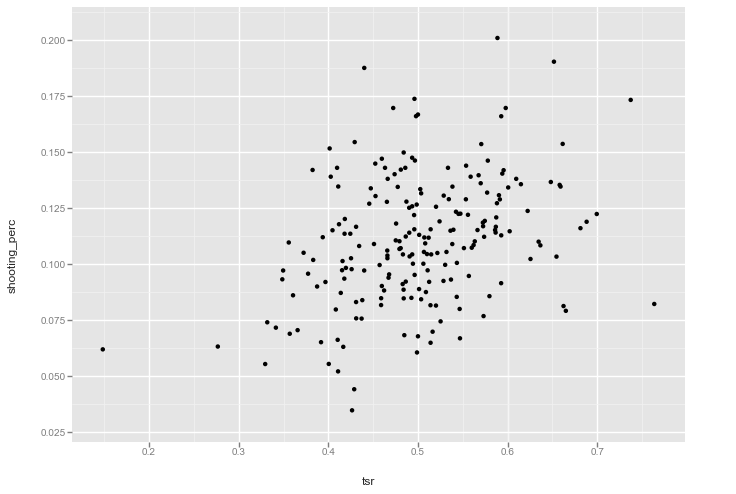

<ggplot: (-9223363289024993357)>

In [134]:
g = ggplot(tsr, aes(x='tsr', y='shooting_perc')) + geom_point()
g

In [152]:
team_class = shots.groupby(['team_name', 'class_year']).sh_att.sum().to_frame().reset_index()
team_full = shots.groupby(['team_name']).sh_att.sum().to_frame().reset_index()
team_year = pd.merge(team_class, team_full, on='team_name', suffixes=("_class", ""))

In [156]:
team_year['perc'] = team_year['sh_att_class'] / team_year['sh_att']
team_year[team_year['class_year'] == 'Sr'].sort_values('perc', ascending=False)[0:10]

,team_name,class_year,sh_att_class,sh_att,perc
782,Western Ill.,Sr,130,171,0.760234
798,Wisconsin,Sr,163,219,0.744292
337,La Salle,Sr,166,237,0.700422
475,Notre Dame,Sr,171,245,0.697959
309,Incarnate Word,Sr,138,201,0.686567
655,Stony Brook,Sr,159,236,0.673729
110,Clemson,Sr,175,281,0.622776
165,Detroit Mercy,Sr,137,220,0.622727
551,Robert Morris,Sr,105,174,0.603448
743,VCU,Sr,130,217,0.599078


In [86]:
shots.team_name.sort_values().unique()

array(['Air Force', 'Akron', 'Albany (NY)', 'American', 'Appalachian St.',
       'Army West Point', 'Belmont', 'Binghamton', 'Boston College',
       'Boston U.', 'Bowling Green', 'Bradley', 'Brown', 'Bryant',
       'Bucknell', 'Butler', 'CSU Bakersfield', 'CSUN', 'Cal Poly',
       'Cal St. Fullerton', 'California', 'Campbell', 'Canisius',
       'Central Ark.', 'Central Conn. St.', 'Charlotte', 'Cincinnati',
       'Clemson', 'Cleveland St.', 'Coastal Caro.', 'Col. of Charleston',
       'Colgate', 'Columbia', 'Cornell', 'Creighton', 'Dartmouth',
       'Davidson', 'Dayton', 'DePaul', 'Delaware', 'Denver',
       'Detroit Mercy', 'Drake', 'Drexel', 'Duke', 'Duquesne', 'ETSU',
       'Eastern Ill.', 'Elon', 'Evansville', 'FGCU', 'FIU', 'Fairfield',
       'Fairleigh Dickinson', 'Fla. Atlantic', 'Fordham', 'Fort Wayne',
       'Furman', 'Ga. Southern', 'Gardner-Webb', 'George Mason',
       'George Washington', 'Georgetown', 'Georgia St.', 'Gonzaga',
       'Grand Canyon', 'Green Bay

Now let's expand those so that we get a row per shot, with a g as the outcome

In [76]:
shots.tail()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
115804,4384327,1608282.0,"Nuss, Eric",167,Cornell,Sr,D,0,1,663,SMU
115806,4384327,1794852.0,"Pedlow, George",167,Cornell,So,F,0,2,663,SMU
115814,4384327,1794846.0,"Adams, Riley",167,Cornell,So,NaN,0,1,663,SMU
115824,4384327,1608285.0,"Griffin, Tommy",167,Cornell,Sr,NaN,0,1,663,SMU
115835,4384327,1572962.0,"Welch, Garrett",663,SMU,Sr,D,1,1,167,Cornell


Unroll it so we get a row for each shot attempt

In [37]:
non_goals = shots.copy()
non_goals['sh_att'] = non_goals.sh_att - non_goals.goals
non_goals['goals'] = 0
non_goals = non_goals[non_goals.sh_att > 0]
non_goals.tail()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
115800,4384327,1927518.0,"Hansan, Tommy",167,Cornell,Fr,MF,0,1,663,SMU
115804,4384327,1608282.0,"Nuss, Eric",167,Cornell,Sr,D,0,1,663,SMU
115806,4384327,1794852.0,"Pedlow, George",167,Cornell,So,F,0,2,663,SMU
115814,4384327,1794846.0,"Adams, Riley",167,Cornell,So,NaN,0,1,663,SMU
115824,4384327,1608285.0,"Griffin, Tommy",167,Cornell,Sr,NaN,0,1,663,SMU


In [38]:
goals = shots.copy()
goals = goals[goals.goals > 0]
goals['sh_att'] = 1
goals.tail()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
115726,4413218,1808925.0,"Ozor, Jerry",68,Boston U.,So,M,1,1,285,Holy Cross
115746,4413218,1808926.0,"McDonnell, Matt",68,Boston U.,So,F,1,1,285,Holy Cross
115763,4384327,1572966.0,"Cichero, Mauro",663,SMU,Sr,F,1,1,167,Cornell
115773,4384327,1786666.0,"McLaughlin, Garrett",663,SMU,So,F,1,1,167,Cornell
115835,4384327,1572962.0,"Welch, Garrett",663,SMU,Sr,D,1,1,167,Cornell


In [39]:
goals_rep = pd.DataFrame([goals.ix[idx]
                       for idx in goals.index 
                       for _ in range(goals.ix[idx]['goals'])]).reset_index(drop=True)

In [40]:
goals_rep['goals'] = 1
goals_rep.groupby('player_name').goals.sum().sort_values(ascending=False)[0:10]

player_name
Guirassy, Mamadou     16
Roberts, Kieran       15
Patino, Santiago      15
Forrest, Mark         15
O'Grady, Jamie        14
Brodacki, Niklas      14
Musovski, Danny       14
Bakero, Jon           13
Donnelly, JJ          13
Mastrangelo, Mario    13
Name: goals, dtype: int64

Looks good

In [41]:
non_goals_rep = pd.DataFrame([non_goals.ix[idx]
                       for idx in non_goals.index 
                       for _ in range(non_goals.ix[idx]['sh_att'])]).reset_index(drop=True)

In [42]:
non_goals_rep['sh_att'] = 1
non_goals_rep.tail()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
37749,4384327,1608282.0,"Nuss, Eric",167,Cornell,Sr,D,0,1,663,SMU
37750,4384327,1794852.0,"Pedlow, George",167,Cornell,So,F,0,1,663,SMU
37751,4384327,1794852.0,"Pedlow, George",167,Cornell,So,F,0,1,663,SMU
37752,4384327,1794846.0,"Adams, Riley",167,Cornell,So,NaN,0,1,663,SMU
37753,4384327,1608285.0,"Griffin, Tommy",167,Cornell,Sr,NaN,0,1,663,SMU


In [43]:
unrolled_df = pd.concat([goals_rep, non_goals_rep], axis=0)
unrolled_df.head()

,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
0,4378055,1908773.0,"Ekdahl, George",19651,High Point,Fr,NaN,1,1,290,Howard
1,4379236,1790668.0,"Weyant, Colin",391,UMBC,So,M,1,1,290,Howard
2,4382728,1800888.0,"Matteo, Ryan",813,Yale,So,M,1,1,290,Howard
3,4382728,1800927.0,"Leisman, John",813,Yale,So,NaN,1,1,290,Howard
4,4391432,1906423.0,"Donnelly, JJ",115,Campbell,Fr,NaN,1,1,290,Howard


In [44]:
unrolled_df.groupby('player_name').goals.sum().sort_values(ascending=False)[0:10]

player_name
Guirassy, Mamadou      16
Forrest, Mark          15
Patino, Santiago       15
Roberts, Kieran        15
O'Grady, Jamie         14
Brodacki, Niklas       14
Musovski, Danny        14
Godoy, Giovanni        13
Mastrangelo, Mario     13
McLaughlin, Garrett    13
Name: goals, dtype: int64

In [45]:
unrolled_df.groupby('player_name').sh_att.sum().sort_values(ascending=False)[0:10]

player_name
Roldan, Alex           90
Roberts, Kieran        90
Guirassy, Mamadou      89
Gallagher, Jon         78
Bye, Brandon           77
Steeves, Mac           77
Donnelly, JJ           70
Forrest, Mark          66
Thiam, Abdou Mbacke    65
Moon, Nick             64
Name: sh_att, dtype: int64

In [46]:
unrolled_df.shape

(42508, 11)

In [47]:
unrolled_df.sh_att.sum()

42508

Good it's all been recovered. Let's write that out now for a separate analysis file

In [48]:
unrolled_df.to_csv("ncaa_by_shot.csv")

Data exploration - in how many games do teams play multiple goalies? It would be worthwhile to add goalkeepers to the model, but without parsing play by play data the correct goalie could be trickier to pick out

In [49]:
df.columns.values

array(['game_id', 'section_id', 'player_id', 'player_name', 'player_url',
       'position', 'goals', 'assists', 'sh_att', 'sog', 'fouls',
       'red_cards', 'yellow_cards', 'gc', 'goal_app', 'ggs',
       'goalie_min_plyd', 'ga', 'saves', 'shutouts', 'g_wins', 'g_loss',
       'dsaves', 'corners'], dtype=object)

In [51]:
len(df.game_id.unique())

1773

In [52]:
sum(df[df['goalie_min_plyd'] > 0].groupby('game_id').size() > 2)

189

So in 10% of games more than one goalie gets minutes for a team.

All that really matters though is crediting saves - so in how many games does more than one goalie make a save for a team?

In [54]:
sum(df[df['saves'] > 0].groupby('game_id').size() > 2)

103

So like 6% of games. Hmm. That might be too high to do any fuzzy matching. I'd need to dig into the play by play data to get that, which is probably more effort than I'm interested in putting forth right now.